# Aula 15

# Exemplo de visão estéreo

### Eduardo Lobo Lustosa Cabral


## 1. Objetivos

Apresentar a solução de um problema de visão estéreo usando uma RNA.




### Importação das principais bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from glob import glob
import os
from calibrator import calibrate
import cv2

print(tf.__version__)

2.8.2


## 2. Conjunto de dados

O conjunto de dados que vamos utilizar nessa aula é o "New Tsukuba Stereo Dataset" (https://home.cvlab.cs.tsukuba.ac.jp/dataset).

Esse conjunto de dados é composto por quase 1.800 pares de imagens com dimensão 480x480 pixels. Portanto, temos que carregá-lo em versão compactada para depois descompactar.


### 2.1 Carregar conjunto de dados

A célula abaixo instala o `gdown` para carregar um arquivo que está no Google Drive e depois carrega esse arquivo no diretório local "/tmp" do Colab.

In [3]:
import os
import zipfile

local_zip = '/content/images_colab.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content')
zip_ref.close()

ret, mtx, dist, rvecs, tvecs = calibrate('calib/right_cal/*.png')
h,  w = right_imagem.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

Após a descompressão do arquivo de dados é criado o diretório "/tmp/TsukubaStereo" com dois subdiretórios: "images" e "disparityl", onde estão as imagens e os mapas de disparidades. 

O diretório "images" é subdividido nos diretórios "left" e "right" onde ficam as imagens das câmeras esquerda e direita respectivamente. O diretório "disparity" é subdividido nso diretórios "left" e "right" onde ficam os mapas de diretórios referentes às imagens da esquerda e da direita respectivamente. Nesse exemplo vamos usar o mapa de disparidade referente è câmera da esquerda.

Na célula abaixo são criadas as listas dos arquivos contidos nesses diretórios.

In [4]:
# Define diretório onde se encontram as imagens
left_image_path = '/content/images_colab/leftinho'
right_image_path = '/content/images_colab/rightinho'


# Escolhe tipos de arquivos desejados
glob_left_imgs = os.path.join(left_image_path, '*.png')
glob_right_imgs = os.path.join(right_image_path, '*.png')


# Cria lista dos nomes dos arquivos
left_img_paths = glob(glob_left_imgs)
right_img_paths = glob(glob_right_imgs)


# Ordena lista dos arquivos
left_img_paths.sort()
right_img_paths.sort()

# Apresenta numero de imagens
print('Número de imagens da esquerda:', len(left_img_paths))
print('Número de imagens da direita:', len(right_img_paths))
print(' ')

# Imprime nomes e paths dos 5 primeiros arquivos das listas
print('Nomes dos 5 primeiros arquivos das listas:')
print(' ')
print(left_img_paths[:5])
print(' ')
print(right_img_paths[:5])
print(' ')

Número de imagens da esquerda: 500
Número de imagens da direita: 500
 
Nomes dos 5 primeiros arquivos das listas:
 
['/content/images_colab/leftinho/left_1661693702546096400.png', '/content/images_colab/leftinho/left_1661693703048086700.png', '/content/images_colab/leftinho/left_1661693703549215800.png', '/content/images_colab/leftinho/left_1661693704051095900.png', '/content/images_colab/leftinho/left_1661693704553087600.png']
 
['/content/images_colab/rightinho/right_1661693702546096400.png', '/content/images_colab/rightinho/right_1661693703048086700.png', '/content/images_colab/rightinho/right_1661693703549215800.png', '/content/images_colab/rightinho/right_1661693704051095900.png', '/content/images_colab/rightinho/right_1661693704553087600.png']
 


In [5]:
# Importa função para embaralhar os dados
from sklearn.utils import shuffle

left_img_paths, right_img_paths = shuffle(left_img_paths, right_img_paths)

# Imprime nomes e paths dos 5 primeiros arquivos das listas
print('Nomes dos 5 primeiros arquivos das listas:')
print(' ')
print(left_img_paths[:5])
print(' ')
print(right_img_paths[:5])
print(' ')

Nomes dos 5 primeiros arquivos das listas:
 
['/content/images_colab/leftinho/left_1661693945417900700.png', '/content/images_colab/leftinho/left_1661693893281947500.png', '/content/images_colab/leftinho/left_1661693877250956400.png', '/content/images_colab/leftinho/left_1661693747140055400.png', '/content/images_colab/leftinho/left_1661693776012104700.png']
 
['/content/images_colab/rightinho/right_1661693945417900700.png', '/content/images_colab/rightinho/right_1661693893281947500.png', '/content/images_colab/rightinho/right_1661693877250956400.png', '/content/images_colab/rightinho/right_1661693747140055400.png', '/content/images_colab/rightinho/right_1661693776012104700.png']
 


Para entender esse conjunto de dados vamos visualizar alguns pares de imagens e o mapa de disparidade.

Dimensões das imagens: (360, 640, 3)
Valor máximo dos pixels das imagens: 255.0


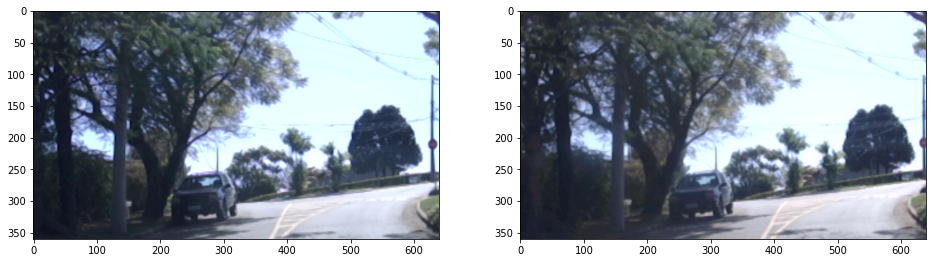

In [6]:
# Importa função para ler imagem
from keras.preprocessing.image import load_img, img_to_array

# Seleção da imagem
index = 1

# Carrega algumas imagens
img_left = load_img(left_img_paths[index])
img_right = load_img(right_img_paths[index])

# convert to numpy array
img_left = img_to_array(img_left)
img_right = img_to_array(img_right)

# Elimina 4o canal
img_left = img_left[:,:,:3]
img_right = img_right[:,:,:3]

# Mostra imagens 
f, pos = plt.subplots(1, 2, figsize=(16, 16))
pos[0].imshow(img_left/255)
pos[1].imshow(img_right/255)

# Mostra dimensões 
print('Dimensões das imagens:', img_left.shape)
print('Valor máximo dos pixels das imagens:', np.max(img_left))

heigth_orig = img_left[0]
weigth_orig = img_left[1]

### 2.2 Divisão dos dados em conjuntos de treinamento e validação

Como essa imagens foram obtidas em sequência, como se fosse um vídeo, e não vamos usar a informação temporal então temos que embaralhar os exemplos, antes de usá-los e antes de dividir os dados nos conjunto de treinamento e validação.

In [7]:
# Conjunto de dados de treinamento
train_left_img_paths = left_img_paths[:400]
train_right_img_paths = right_img_paths[:400]

# Conjunto de dados de validação
val_left_img_paths = left_img_paths[400:]
val_right_img_paths = right_img_paths[400:]

# Numero de exemplos
print(len(train_left_img_paths), len(train_right_img_paths))
print(len(val_left_img_paths), len(val_right_img_paths))

400 400
100 100


## 3. Gerador de dados

A dimensão das imagens de entrada e o mapa de disparidade são 480x640x3 e o conjunto de dados de treinamento possui 1.500 exemplos e o de validação 300 exemplos. Assim, não é possível carregar todas essas em tensores, portanto, temos que usar geradores de dados para carregar os lote de exemplos de treinamento e de validação um de cada vez.

Na célula abaixo é criado um gerador que carrega as imagens dos diretórios onde se encontram e realiza as seguintes operações para criar os exemplos de treinamento e de validação:

1. Carrega as imagens da esquerda, da direita e o mapa de disparidade
2. Transforma as imagens em tensores
3. Redimensiona as imagens e o mapa de disparidade (essa imagens são muito grandes para o hardware disponível)
4. Normaliza as imagem de entrada para que os valores dos seus pixels sejam números reais entre 0 e 1

In [8]:
from keras.preprocessing.image import load_img, img_to_array

# Cria gerador para ser usado com o Keras
def batch_generator(left_img_paths, right_img_paths, img_size, m_exemplos, batchsize):
    # Inicializa loop infinito que termina no final do treinamento
    while True:
        
        # Loop para selecionar imagens de cada lote
        for start in range(0, m_exemplos, batchsize):
           
            # Inicializa lista de imagens com máscara e sem máscara
            batch_left_img, batch_right_img, batch_out_img = [], [], []
        
            end = min(start + batchsize, m_exemplos)
            for i in range(start, end):
                # Carrega images e o mapa de disparidade
                left_imagem = load_img(left_img_paths[i])
                right_imagem = load_img(right_img_paths[i])
                
                # Converet para tensor 
                left_imagem = img_to_array(left_imagem)
                right_imagem = img_to_array(right_imagem)

                # Elimina 4o canal
                left_imagem = left_imagem[:,:,:3]
                right_imagem = right_imagem[:,:,:3]
                
                # Redimensiona imagens e normaliza
                left_imagem = tf.image.resize(left_imagem, img_size)/255.
                right_imagem = tf.image.resize(right_imagem, img_size)/255.

                dst = cv2.undistort(right_imagem, mtx, dist, None, newcameramtx)
                # crop the image
                x,y,w,h = roi
                right_imagem = dst[y:y+h, x:x+w]
                ret, mtx, dist, rvecs, tvecs = calibrate('calib/left_cal/*.png')
                h,  w = left_imagem.shape[:2]
                newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
                dst = cv2.undistort(right_imagem, mtx, dist, None, newcameramtx)
                # crop the image
                x,y,w,h = roi
                right_imagem = dst[y:y+h, x:x+w]

                # Adiciona imagem original e segmentada aos lotes
                batch_left_img.append(left_imagem)
                batch_right_img.append(right_imagem)
                batch_out_img.append(right_imagem)
            
            yield [np.stack(batch_left_img, axis=0), np.stack(batch_right_img, axis=0)], [np.stack(batch_out_img, axis=0)]
            #Não tenho certeza se deixa o [] na saída

As duas células abaixo testam o gerador de dados nos exemplos de treinamento e de validação.

Dimensão dos tensores de imagens = (16, 240, 320, 3) (16, 240, 320, 3) (16, 240, 320, 3)
Nomes dos arquivos:
/content/images_colab/leftinho/left_1661693945417900700.png
/content/images_colab/rightinho/right_1661693945417900700.png


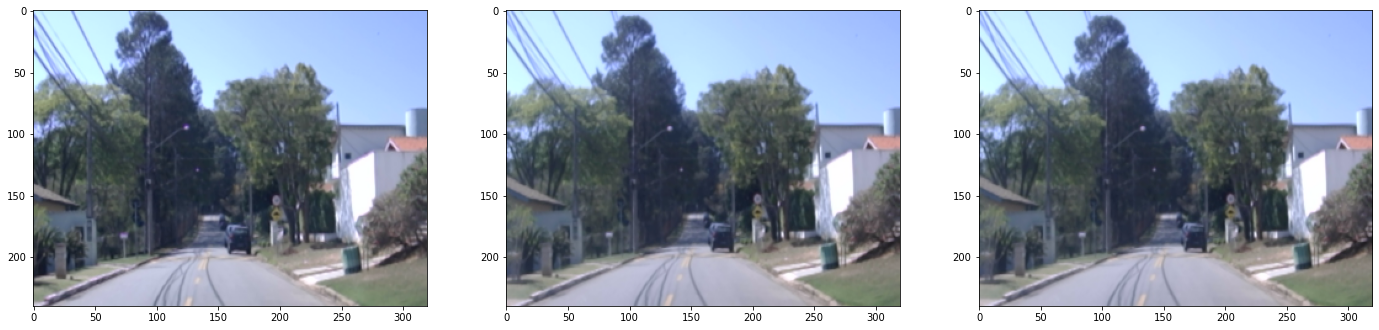

In [9]:
# Número de exemplos
m_train = len(train_left_img_paths)
m_val = len(val_left_img_paths)

# Define tamanho do lote
batch_size = 16

# Dimensão desejada para as imagens
img_size = (640, 360)


# Instancia o gerador de dados de treinamento
train_datagen = batch_generator(train_left_img_paths, train_right_img_paths, img_size, m_train, batchsize=batch_size)

# Usa o gerador uma vez
[left_img_batch, right_img_batch], [out_img_batch] = next(train_datagen)

# Apresenta dimensão dos tensores de entrada de saída
print('Dimensão dos tensores de imagens =', left_img_batch.shape, right_img_batch.shape, out_img_batch.shape)

# Mostra uma imagem dos lotes gerados
index = 0
print('Nomes dos arquivos:')
print(train_left_img_paths[index])
print(train_right_img_paths[index])
f, pos = plt.subplots(1, 3, figsize=(24, 16))
pos[0].imshow(left_img_batch[index])
pos[1].imshow(right_img_batch[index])
pos[2].imshow(out_img_batch[index])
plt.show()

Dimensão dos tensores de imagens = (16, 240, 320, 3) (16, 240, 320, 3) (16, 240, 320, 3)
Nomes das imagens:
/content/images_colab/leftinho/left_1661693729105074300.png
/content/images_colab/rightinho/right_1661693729105074300.png


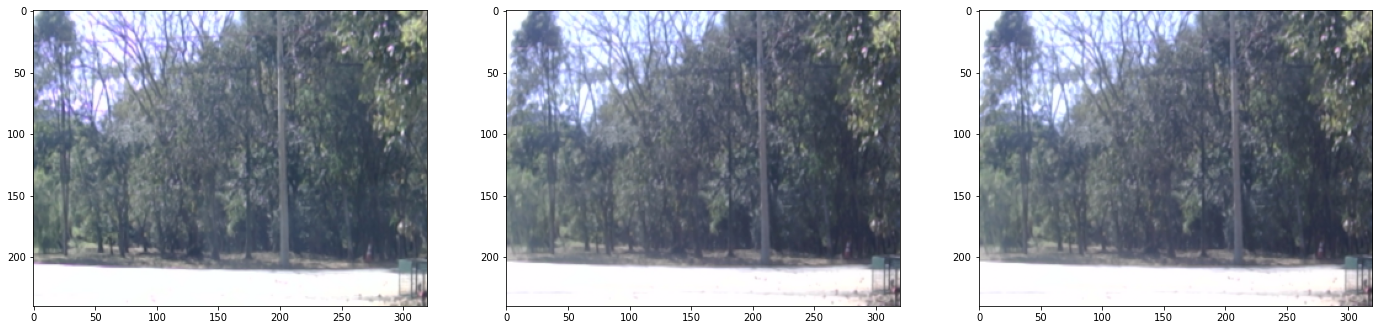

In [10]:
# Instancia o gerador de dados de validação
val_datagen = batch_generator(val_left_img_paths, val_right_img_paths, img_size, m_val, batchsize=batch_size)

# Usa o gerador uma veze
[left_img_batch, right_img_batch], [out_img_batch] = next(val_datagen)

# Apresenta dimensão dos tensores de entrada de saída
print('Dimensão dos tensores de imagens =', left_img_batch.shape, right_img_batch.shape, out_img_batch.shape)

# Mostra uma imagem dos lotes gerados
index = 1
print('Nomes das imagens:')
print(val_left_img_paths[index])
print(val_right_img_paths[index])
f, pos = plt.subplots(1, 3, figsize=(24, 16))
pos[0].imshow(left_img_batch[index])
pos[1].imshow(right_img_batch[index])
pos[2].imshow(out_img_batch[index])
plt.show()

In [11]:
# Calcula números de lotes por época
train_steps = len(train_left_img_paths) // batch_size
val_steps = len(val_left_img_paths) // batch_size

print('Passos de treinamento:', train_steps)
print('Passos de validação:', val_steps)

Passos de treinamento: 25
Passos de validação: 6


## 4. Reconstrução

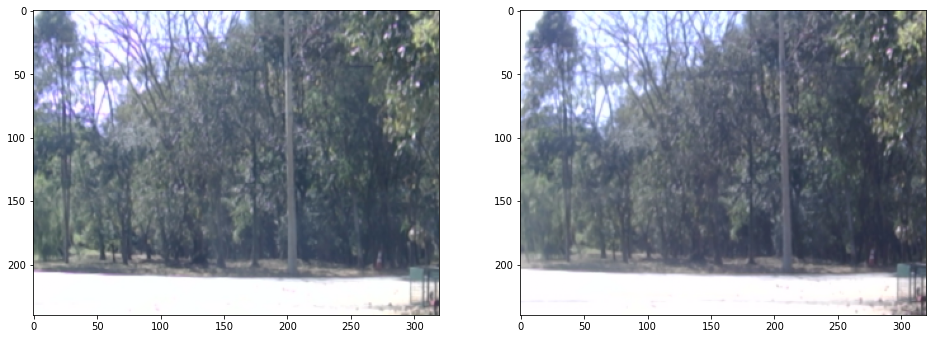

In [12]:
# Mostra uma imagem dos lotes gerados
index = 1
imgL = left_img_batch[index]
imgR = right_img_batch[index]

f, pos = plt.subplots(1, 2, figsize=(16, 16))
pos[0].imshow(imgL)
pos[1].imshow(imgR)
plt.show()

In [13]:
print(imgL.shape, imgR.shape)

(240, 320, 3) (240, 320, 3)


### Camada de reconstrução

In [14]:
# Classe para reconstrutor
class Reconstructor(tf.keras.layers.Layer):
    def __init__(self, height=40, width=40, num_channels=3, name="rec_img"):
        super(Reconstructor, self).__init__(name=name)
        self.height = height
        self.width = width
        self.num_channels = num_channels

    def compute_output_shape(self, input_shape):
        return [None, self.height, self.width, 1]

    def get_config(self):
        return {
            'height': self.height,
            'width': self.width,
        }
    
    def build(self, input_shape):
        print("Building Reconstruction Layer with input shape:", input_shape)

    def repeat(self, x, n_repeats):
        #with tf.variable_scope('_repeat'):
        rep = tf.tile(tf.expand_dims(x, 1), [1, n_repeats])
        return tf.reshape(rep, [-1])

    def interpolate(self, im, x, y, _num_batch):
        _height_f = tf.cast(self.height, tf.float32)
        _width_f  = tf.cast(self.width,  tf.float32)        

        # handle both texture border types
        _edge_size = 1
        im = tf.pad(im, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='CONSTANT')
        x = x + _edge_size
        y = y + _edge_size

        x = tf.clip_by_value(x, 0.0,  _width_f - 1 + 2 * _edge_size)

        x0_f = tf.floor(x)
        y0_f = tf.floor(y)
        x1_f = x0_f + 1

        x0 = tf.cast(x0_f, tf.int32)
        y0 = tf.cast(y0_f, tf.int32)
        x1 = tf.cast(tf.minimum(x1_f,  _width_f - 1 + 2 * _edge_size), tf.int32)

        dim2 = (self.width + 2 * _edge_size)
        dim1 = (self.width + 2 * _edge_size) * (self.height + 2 * _edge_size)
        base = self.repeat(tf.range(_num_batch) * dim1, self.height * self.width)
        base_y0 = base + y0 * dim2
        idx_l = base_y0 + x0
        idx_r = base_y0 + x1

        im_flat = tf.reshape(im, tf.stack([-1, self.num_channels]))

        pix_l = tf.gather(im_flat, idx_l)
        pix_r = tf.gather(im_flat, idx_r)

        weight_l = tf.expand_dims(x1_f - x, 1)
        weight_r = tf.expand_dims(x - x0_f, 1)

        return weight_l * pix_l + weight_r * pix_r

    def transform(self, input_images, x_offset, _num_batch):
        _height_f = tf.cast(self.height, tf.float32)
        _width_f  = tf.cast(self.width,  tf.float32)
        
        x_t, y_t = tf.meshgrid(tf.linspace(0.0,   _width_f - 1.0,  self.width),
                               tf.linspace(0.0 , _height_f - 1.0 , self.height))

        x_t_flat = tf.reshape(x_t, (1, -1))
        y_t_flat = tf.reshape(y_t, (1, -1))

        x_t_flat = tf.tile(x_t_flat, tf.stack([_num_batch, 1]))
        y_t_flat = tf.tile(y_t_flat, tf.stack([_num_batch, 1]))

        x_t_flat = tf.reshape(x_t_flat, [-1])
        y_t_flat = tf.reshape(y_t_flat, [-1])

        x_t_flat = x_t_flat + tf.reshape(x_offset, [-1])

        input_transformed = self.interpolate(input_images, x_t_flat, y_t_flat, _num_batch)

        output = tf.reshape(input_transformed, tf.stack([_num_batch, self.height, self.width, self.num_channels]))
        
        return output

    def call(self, input_images,  x_offset):
        _num_batch    = tf.shape(input_images)[0]

        output = self.transform(input_images, x_offset, _num_batch)
        return output

In [15]:
def loss_erro_rec(y_true, y_pred):
    mask = tf.where(y_pred<1e-08,  0., 1.)
    erro = 255*tf.reduce_mean(tf.square(mask*(y_true - y_pred)))
    return erro  

rec = Reconstructor(height=left_img_batch.shape[1], width=left_img_batch.shape[2])


### Rede de extração de catracterísticas

In [16]:
from tensorflow.keras import models
from tensorflow.keras import layers

# Número de filtros básico
nF = 32

# Rede convolucional de extração de características
def rna_carac(input_shape, nF):
    x0 = layers.Input(shape=input_shape)
    
    # Calculo das características das imagens
    x1 = layers.Conv2D(nF, (5,5), padding='same', activation=layers.LeakyReLU())(x0)
    x2 = layers.Conv2D(nF, (5,5), padding='same', use_bias=False)(x1)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.LeakyReLU()(x2)
    x2 = layers.MaxPool2D(2,2)(x2)

    x3 = layers.Conv2D(nF*2, (5,5), padding='same', activation=layers.LeakyReLU())(x2)
    x4 = layers.Conv2D(nF*2, (5,5), padding='same', use_bias=False)(x3)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.LeakyReLU()(x4)
    x4 = layers.MaxPool2D(2,2)(x4)

    x5 = layers.Conv2D(nF*4, (5,5), padding='same', activation=layers.LeakyReLU())(x4)
    x6 = layers.Conv2D(nF*4, (5,5), padding='same', use_bias=False)(x5)
    x6 = layers.BatchNormalization()(x6)
    x6 = layers.LeakyReLU()(x6) 
    x6 = layers.MaxPool2D(2,2)(x6)  

    x7 = layers.Conv2D(nF*4, (5,5), padding='same', activation=layers.LeakyReLU())(x6)
    x8 = layers.Conv2D(nF*4, (5,5), padding='same', use_bias=False)(x7)
    x8 = layers.BatchNormalization()(x8)
    x8 = layers.LeakyReLU()(x8)  


    # Cria modelo
    rna_carac = models.Model(x0, x8)
    
    return rna_carac

input_shape = (640, 360, 3)
rnaCV = rna_carac(input_shape, nF)

rnaCV.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 240, 320, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 240, 320, 32)      25600     
                                                                 
 batch_normalization (BatchN  (None, 240, 320, 32)     128       
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 240, 320, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 120, 160, 32)     0         
 )                                                           

In [17]:
img_carac = rnaCV(left_img_batch)
print(img_carac.shape)


(16, 30, 40, 128)


## Rede completa

In [25]:
#### Rede de calculo da profundidade ####
input_shape = (img_size[0], img_size[1], 3)

# Define entradas
input_left = tf.keras.layers.Input(shape=input_shape)
input_right = tf.keras.layers.Input(shape=input_shape)

# Extrai características
xL = rnaCV(input_left)
xR = rnaCV(input_right)

# Cocatena com características
ac = layers.Concatenate(axis=-1)([xL, xR])

# Aplica convolução
x2 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu', strides=(2,2))(ac)
x2 = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x2)

x3 = layers.Conv2DTranspose(32, (3,3), padding='same', activation='relu', strides=(2,2))(x2)
x3 = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x3)

# Calcula da disparidade
x4 = layers.Conv2DTranspose(16, (3,3), padding='same', activation='relu', strides=(2,2))(x3)
x4 = layers.Conv2D(16, (3,3), padding='same', activation='relu')(x4)

x5 = layers.Conv2D(1, (1,1), padding='same', activation='relu')(x4)

disp_layer = layers.Lambda(lambda x: tf.squeeze(x), name='disp')
disp = disp_layer(x5)

# Imagem da direita reconstruída usando a imagem esquerda e a disparidade
img_rec = rec(input_left, disp)

# Create the Keras model.
rna_stereo = keras.Model(inputs=[input_left, input_right], outputs=[img_rec])                   
             
# Sumário da rede             
rna_stereo.summary()    

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_5 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 30, 40, 128)  1616960     ['input_4[0][0]',                
                                                                  'input_5[0][0]']          

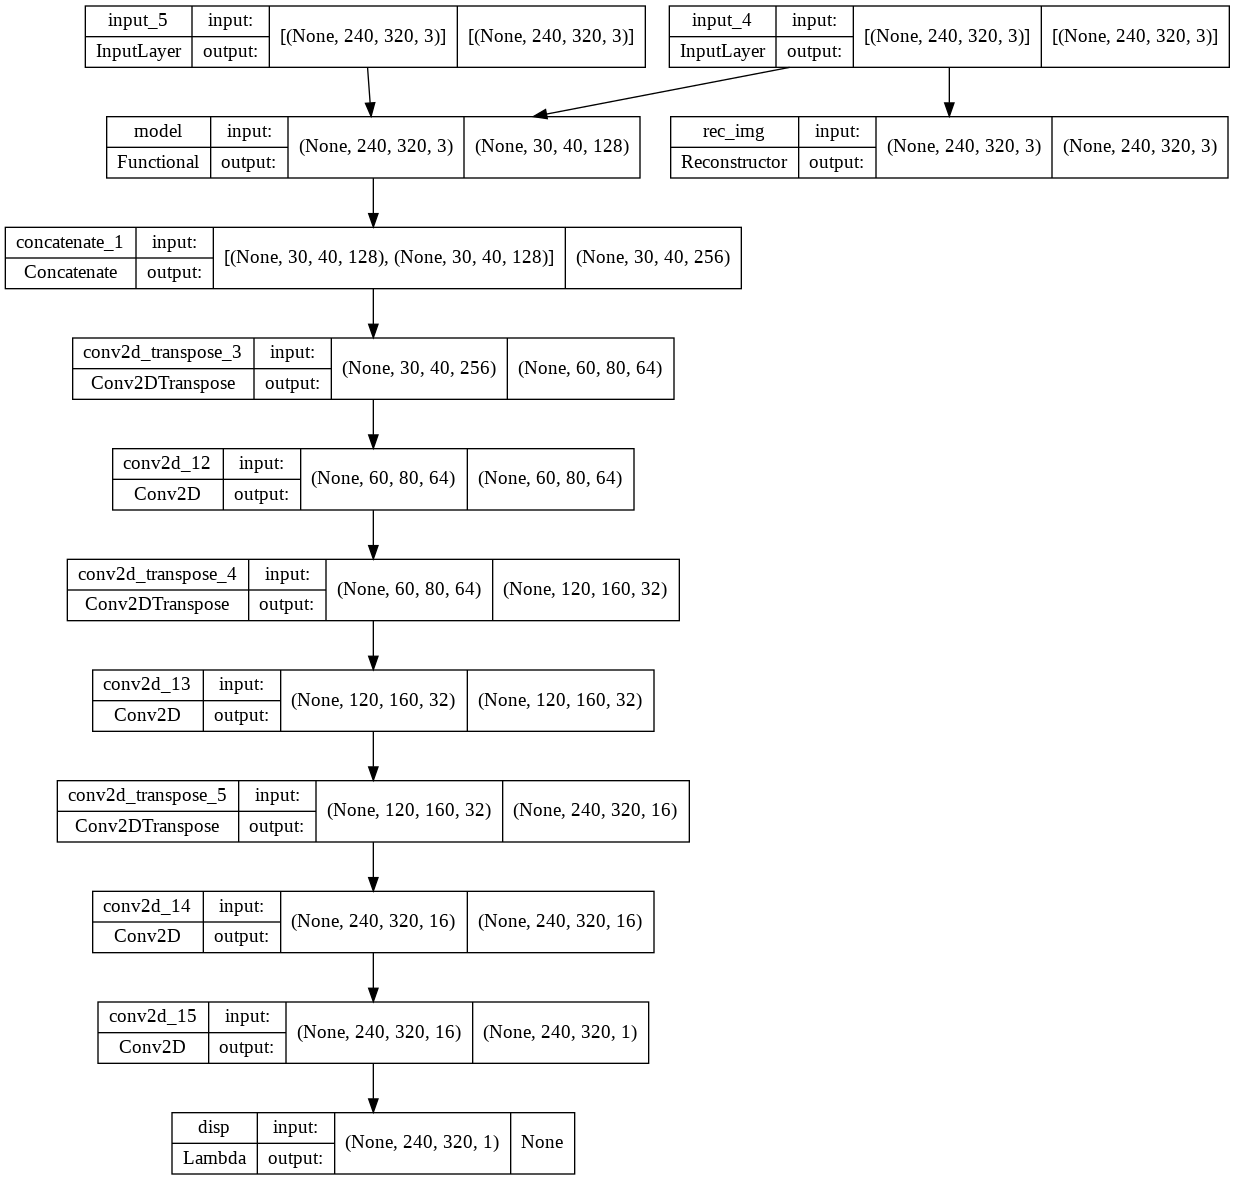

In [26]:
# Gera um esquema gráfico da rede
from tensorflow.keras.utils import plot_model
plot_model(rna_stereo, show_shapes=True, to_file='rna_stereo.png')

In [28]:
img_rec = rna_stereo([left_img_batch, right_img_batch])   
print(img_rec.shape, disp.shape)

(16, 240, 320, 3) <unknown>


### 4.2 Compilação e treinamento

A compilação da rede é feita usando os seguintes parâmetros:
    
1. Método de otimização: Adam com taxa de aprendizado de 0.001
2. Função de custo: erro quadrático médio (mse)
3. Métrica: erro absoluto médio (mae)

In [29]:
# Importa classe dos otimizadores
from tensorflow.keras import optimizers

# Define otimizador Adam
adam = optimizers.Adam(learning_rate=0.001, decay=1e-03)

# Compilação do autoencoder
rna_stereo.compile(optimizer=adam, 
                   loss={
                         'rec_img': loss_erro_rec},
                   metrics={
                         'rec_img': 'mae'})

O treinamento da rede é realizado usando 100 épocas. 

Como o treinamento é demorado, então, é conveniente utilizar um `callback` para salvar os parâmetros da rede durante o processo de treinamento.

In [30]:
# Importa callback para salvar modelo durante treinamento
from tensorflow.keras.callbacks import ModelCheckpoint

# Define o callback para salvar os parâmetros
checkpointer = ModelCheckpoint('rna_stereo_CVN_REC_weigths', verbose=1, save_best_only=True, save_weights_only=True)

# Treinamento da rede
results = rna_stereo.fit(
          batch_generator(train_left_img_paths, train_right_img_paths, img_size, m_train, batchsize=batch_size),
          steps_per_epoch=train_steps,
          epochs=100,
          validation_data=batch_generator(val_left_img_paths, val_right_img_paths, img_size, m_val, batchsize=batch_size),
          validation_steps=val_steps,
          callbacks=[checkpointer],
          verbose=1)

Epoch 1/100
25/25 [==============================] - ETA: 0s - loss: 5.3170 - mae: 0.0898
Epoch 1: val_loss improved from inf to 5.12045, saving model to rna_stereo_CVN_REC_weigths
25/25 [==============================] - 24s 752ms/step - loss: 5.3170 - mae: 0.0898 - val_loss: 5.1204 - val_mae: 0.0893
Epoch 2/100
25/25 [==============================] - ETA: 0s - loss: 5.1911 - mae: 0.0888
Epoch 2: val_loss improved from 5.12045 to 4.99114, saving model to rna_stereo_CVN_REC_weigths
25/25 [==============================] - 18s 746ms/step - loss: 5.1911 - mae: 0.0888 - val_loss: 4.9911 - val_mae: 0.0883
Epoch 3/100
25/25 [==============================] - ETA: 0s - loss: 5.0734 - mae: 0.0879
Epoch 3: val_loss improved from 4.99114 to 4.93822, saving model to rna_stereo_CVN_REC_weigths
25/25 [==============================] - 18s 748ms/step - loss: 5.0734 - mae: 0.0879 - val_loss: 4.9382 - val_mae: 0.0877
Epoch 4/100
25/25 [==============================] - ETA: 0s - loss: 4.9329 - mae: 

### 4.3 Salva a rede treinada

Após o término do processo de treinamento a rede e os seus parâmetros são salvos. Pode-se carregar os parâmetros da rede usando.

In [31]:
# Restore the weights
rna_stereo.load_weights('rna_stereo_CVN_REC_weigths')#'my_checkpoint_classic')

### 4.4 Resultados

As células abaixo apresentam os gráficos do processo de treinamento e a avaliação da rede pelo cálculo da função de custo e métrica para os dados de treinamento e validação.

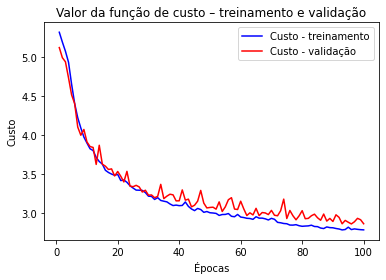

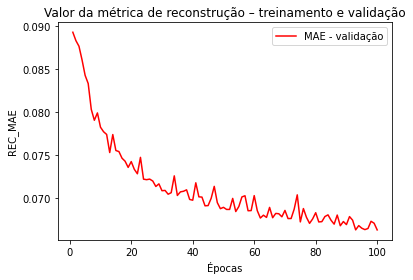

In [41]:
# Obtém dicionário com os resultados do treinamento
results_dict = results.history

# Salva custos, métricas e epocas em vetores 
custo = results_dict['loss']
#rec_mae = results_dict['rec_img_mae']
#disp_mae = results_dict['disp_mae']
val_custo = results_dict['val_loss']
#val_rec_mae = results_dict['val_rec_img_mae']
#val_disp_mae = results_dict['val_disp_mae']
val_mae = results_dict['val_mae']

# Cria vetor de épocas
epocas = range(1, len(custo) + 1)

# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento')
plt.plot(epocas, val_custo, 'r', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()

# Gráfico dos valores da métrica
#plt.plot(epocas, rec_mae, 'b', label='MAE - treinamento')
plt.plot(epocas, val_mae, 'r', label='MAE - validação')
plt.title('Valor da métrica de reconstrução – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('REC_MAE')
plt.legend()
plt.show()

# Gráfico dos valores da métrica


In [37]:
results_dict.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

In [42]:
custo_metrica_train = rna_stereo.evaluate(batch_generator(train_left_img_paths, train_right_img_paths, img_size, m_train, batchsize=batch_size), steps=train_steps)
custo_metrica_val = rna_stereo.evaluate(batch_generator(val_left_img_paths, val_right_img_paths, img_size, m_val, batchsize=batch_size), steps=val_steps)

6/6 [==============================] - 2s 409ms/step - loss: 2.8613 - mae: 0.0664


## 5. Previsões da rede

Vamos verificar se a rede desenvolvida é eficaz em realizar segmentação de imagens. Para isso vamos calcular a sua previsão para alguns exemplos  do conjunto de validação e verificar a qualidade o mapa de disparidade e compará-lo com o mapa de dispatidade real.

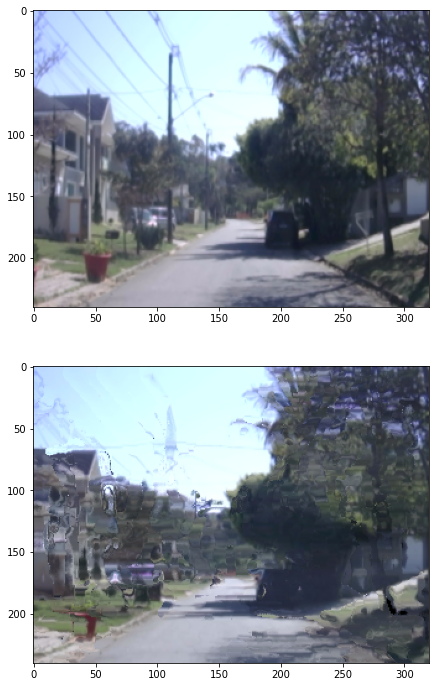

In [47]:
# Instancia o gerador de dados de validação
datagen = batch_generator(val_left_img_paths, val_right_img_paths, img_size, m_val, batchsize=8)

# Gera lote de exemplos de valiação
[left_img_batch, right_img_batch], [out_img_batch] = next(datagen) 

# Calcula previsão da rede para o lote de validação gerado
img_prev_batch = rna_stereo.predict([left_img_batch, right_img_batch])

# Seleciona exemplo para análise
index = 6
left_img = left_img_batch[index]
right_img = right_img_batch[index]
img_prev = img_prev_batch[index]
#disp_prev = disp_prev_batch[index]

# Retira eixos dos exemplos
left_img = np.squeeze(left_img)
right_img = np.squeeze(right_img)
#disp_prev = np.squeeze(disp_prev)

# Mostra resultados do exemplos slecionado
f, pos = plt.subplots(2, 1, figsize=(12, 12))
pos[0].imshow(right_img)
pos[1].imshow(img_prev)
#pos[1,1].imshow(disp_prev, cmap='gray')
plt.show()

In [48]:
# Calcula erro de previsão disparidade


# Calcula erro de previsão de recosntrução
img_batch = np.squeeze(img_prev_batch)
erro = np.mean(100*np.mean(np.abs(right_img_batch - img_batch)))/np.mean(right_img_batch)
print('Erro absoluto médio percentual recosntrução (%):', erro)

Erro absoluto médio percentual recosntrução (%): 11.678042259203337


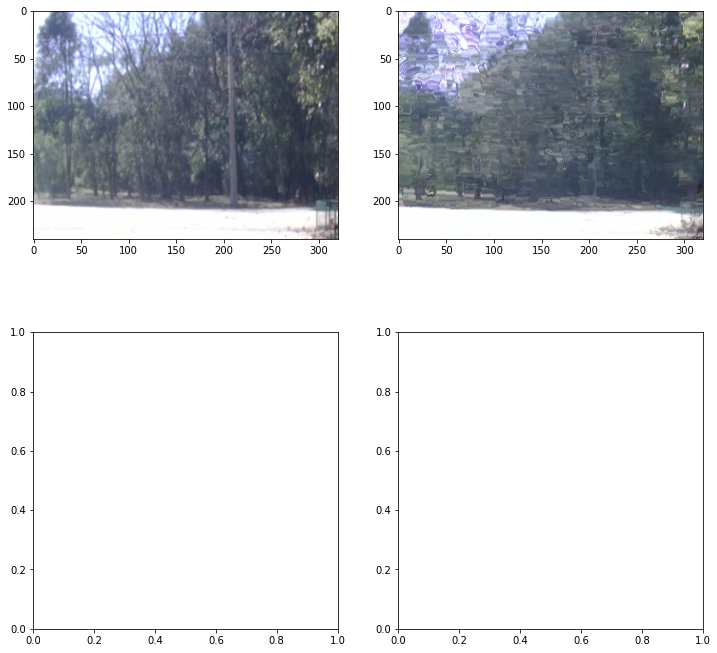

In [50]:
# Seleciona exemplo para análise
index = 1
left_img = left_img_batch[index]
right_img = right_img_batch[index]
#disp_prev = disp_prev_batch[index]
img_prev = img_prev_batch[index]

# Retira eixos dos exemplos
left_img = np.squeeze(left_img)
right_img = np.squeeze(right_img)
#disp_prev = np.squeeze(disp_prev)
img_prev = np.squeeze(img_prev)

# Mostra resultados do exemplos slecionado
f, pos = plt.subplots(2, 2, figsize=(12, 12))
pos[0,0].imshow(right_img)
pos[0,1].imshow(img_prev)
#pos[1,1].imshow(disp_prev, cmap='gray')
plt.show()

In [ ]:
# Calcula erro de previsão 


# Apresenta alguns valores das imagens segmentadas
print(disp_prev[index,:].astype(int))

### Teste com imagens diferentes

Tem que carregar a imagem.

In [53]:
from keras.preprocessing.image import load_img, img_to_array

left_imagem = load_img('/content/left_1661700892724891100.png')
right_imagem = load_img('/content/right_1661700892724891100.png')

img_left = img_to_array(left_imagem)
img_right = img_to_array(right_imagem)

print(img_left.shape, img_right.shape)
print(np.max(img_left), np.max(img_right))

(360, 640, 3) (360, 640, 3)
255.0 255.0


In [54]:
img_left = tf.image.resize(img_left, img_size)/255.
img_right = tf.image.resize(img_right, img_size)/255.

img_left = np.expand_dims(img_left, axis=0)
img_right = np.expand_dims(img_right, axis=0)

print(np.max(img_left), np.max(img_right))

1.0 1.0


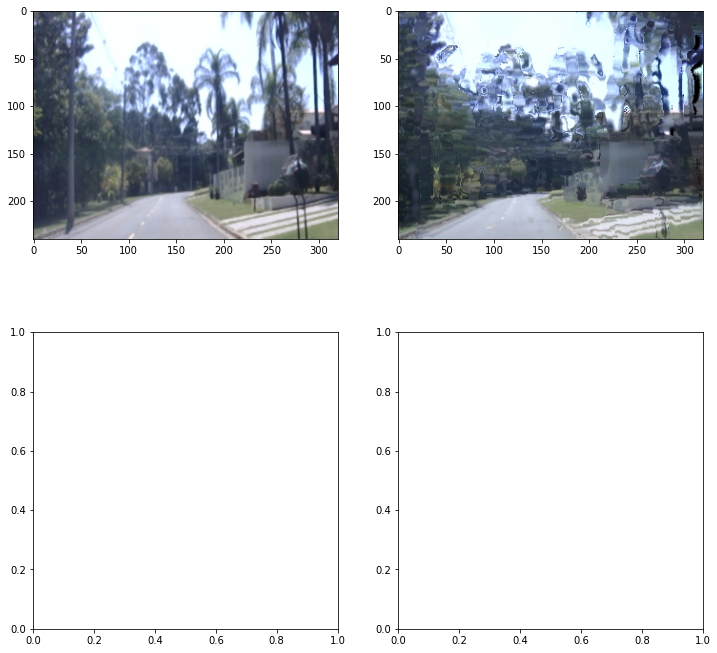

In [56]:
# Mostra resultados do exemplos selecionado
img_prev = rna_stereo.predict([img_left, img_right])

f, pos = plt.subplots(2, 2, figsize=(12, 12))
pos[0,0].imshow(img_right[0])
pos[0,1].imshow(img_prev[0])
plt.show()

In [ ]:
# Calcula erro de previsão 


# Apresenta alguns valores das imagens segmentadas
print(disp_prev[128,:].astype(int))

In [57]:
# Calculo do erro de reconstrução
erro_rec = np.mean(100*np.abs(img_prev - img_right))/np.mean(img_right)
print('Erro absoluto médio percentual (%):', erro_rec)

Erro absoluto médio percentual (%): 15.124584
